In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# FEATURE ATTACK

In [2]:
dset_avg = pd.DataFrame()
for dset in ['CTU', 'ToN_IoT']:
    all_avgs = pd.DataFrame()
    for model in ['rf', 'egraphsage', 'linegraphsage']:
        concats = pd.DataFrame()
        if dset == 'CTU':
            atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
        else:
            atks = ['ddos', 'backdoor', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
        
        for atk in atks:
            if model == 'rf':
                baseline = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
                attack = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/feature_attack.csv", index_col=0)
            else:
                baseline = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
                attack = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_feature_recall.csv", index_col=0)
        
            attack.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9]
            avg_data = pd.concat([baseline.loc['0', ['recall']].rename({'recall': 0}), attack.mean()]).to_frame()
            concats = pd.concat([concats, avg_data], axis=1)
            
        all_avgs = pd.concat([all_avgs,
                            concats.mean(axis=1).to_frame().assign(frame=f"{model}".capitalize()).rename(columns={'frame': 'Model'})])
    dset_avg = pd.concat([dset_avg, all_avgs.assign(frame=f'{dset}')])
# dset_avg

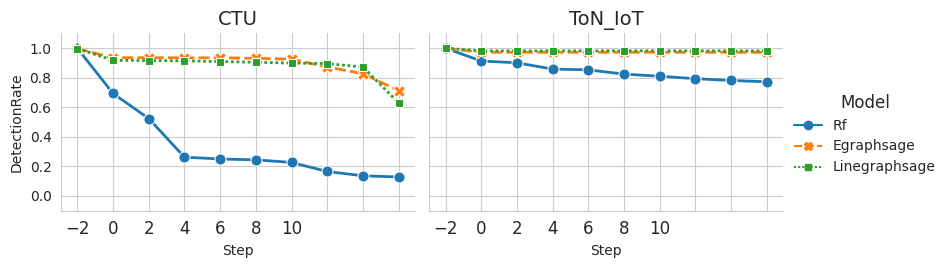

In [3]:
data_to_plot = dset_avg.reset_index().rename(columns={'index': 'Step', 0: 'DetectionRate', 'frame': 'DSet'})
sns.set_style('whitegrid')
g = sns.relplot(data = data_to_plot, x='Step', y='DetectionRate', hue='Model', height=2.7, aspect=1.5, style='Model', col='DSet', kind='line', markers=True, markersize=8, linewidth=2)
xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
g.set(xticks=xticks, ylim=[-0.1, 1.1], yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
g.set_xticklabels(size=12)
g.set_titles(col_template='{col_name}', size=14)
plt.setp(g._legend.get_title(), fontsize=12)
g.fig.savefig('figures/total/feature_attacks.pdf')

# ADD EDGE ATTACK

In [4]:
def produce_plot_data(baseline_dict, atk_dict, all_metrics = False):
    plot_data = pd.DataFrame()
    for key, df in atk_dict.items():
        baseline_data = baseline_dict[key]
        base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}
        ),
            baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
                {'precision': 'Ben Precision',
                'recall': 'Ben Recall',
                'f1-score': 'Ben F1-Score'}
            )], axis = 0).to_frame().T
        atk_df = pd.concat([base_data, atk_dict[key]], axis = 0)
        if not all_metrics:
            atk_df.drop(columns=['Mal Precision', 'Mal F1-Score', 'Ben Recall', 'Ben Precision', 'Ben F1-Score'], inplace=True)
            
        atk_df = pd.melt(atk_df, var_name='metric', ignore_index=False)
        atk_df['Step'] = list(range(len([0, 1, 2, 5, 10, 20]))) * (len(atk_df) // 6)
        atk_df['Botnet'] = key.capitalize()
        
        plot_data = pd.concat([plot_data, atk_df])
    
    plot_data.rename(columns={'value': 'Detection Rate'}, inplace=True)
    return plot_data

In [7]:
def produce_plot_relplot(plot_data):
    plot_data.rename(columns={'frame': 'Model', 'Step': 'β Step'}, inplace=True)
    grid = sns.relplot(data = plot_data, x='β Step', y='Detection Rate', hue='Botnet', col='Botnet', kind='line', linewidth=2,
                       style='Model', col_wrap=7, palette='tab20', height=1.5, markers=['o', 'X'], markersize = 8, dashes=True, legend=True)
    xticks = [0, 1, 2, 5, 10, 20]
    grid.set(xticks=xticks, yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
             xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])
    
    for ax in grid.axes.flat:
        ax.xaxis.set_ticks(range(len(xticks)))
        ax.xaxis.set_ticklabels(xticks)
        ax.tick_params(labelbottom=True)

    
    grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=14)
    grid.fig.tight_layout(w_pad = 1)
    
    grid.legend.remove()
    grid.fig.legend(handles=grid.legend.legendHandles[-3:], loc=7, bbox_to_anchor=(0.5, 0.1, 0.5, 0.5)) # (0.4, -0.05, 0.5, 0.5)
    return grid.fig

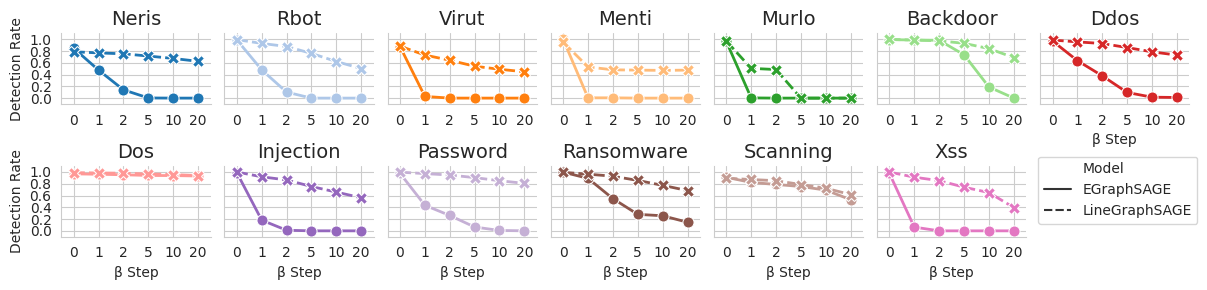

In [9]:
atk_type = 'benign' # This is for C2X_B attack. Set `atk_type` to 'malicious' for C2X_M.

sns.set_style('whitegrid')
model = 'egraphsage'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}_from_C.csv", index_col=0)
        
e_graphsage_data = produce_plot_data(baseline_dict, atk_dict)
    
model = 'linegraphsage'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}_from_C.csv", index_col=0)
        
linegraphsage_data = produce_plot_data(baseline_dict, atk_dict)

data = pd.concat([
    e_graphsage_data.assign(frame='EGraphSAGE'),
    linegraphsage_data.assign(frame='LineGraphSAGE')
], ignore_index=True)

fig = produce_plot_relplot(data)
fig.savefig(f"figures/total/{atk_type}_from_C_big.pdf")

# ADD NODE ATTACK

In [12]:
def produce_add_node_data(baseline_dict, atk_dict, all_metrics = False):
    plot_data = pd.DataFrame()
    for key, df in atk_dict.items():
        baseline_data = baseline_dict[key]
        base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}
        ),
            baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
                {'precision': 'Ben Precision',
                'recall': 'Ben Recall',
                'f1-score': 'Ben F1-Score'}
            )], axis = 0).to_frame().T
        atk_df = pd.concat([base_data, atk_dict[key]], axis = 0)
        atk_df.reset_index(inplace=True)
        atk_df.rename(columns={'index': 'Step'}, inplace=True)
        atk_df = atk_df[atk_df['Num Nodes'] != 2]
        atk_df = atk_df[atk_df['Num Nodes'] != 20]
        atk_df = atk_df[atk_df['Num Nodes'] != 50]
        atk_df = atk_df[atk_df['Num Nodes'] != 200]
        atk_df.fillna(0.0, inplace=True)
        
        if not all_metrics:
            atk_df.drop(columns=['Mal Precision', 'Mal F1-Score', 'Ben Recall', 'Ben Precision', 'Ben F1-Score'], inplace=True)
            
        atk_df = pd.melt(atk_df, id_vars = ['Step', 'Num Nodes'], value_vars=['Mal Recall'], var_name='metric')
        atk_df['Botnet'] = key.capitalize()
        
        baseline = atk_df[atk_df.Step == 0]
        atk_df = atk_df[atk_df.Step != 0]
        for step in [1, 5, 20]:
            tmp = baseline.copy()
            tmp['Num Nodes'] = 0
            tmp['Step'] = step
            atk_df = pd.concat([atk_df, tmp], axis=0)
        
        atk_df = atk_df.sort_values('Num Nodes')
        atk_df = atk_df[atk_df.Step != 2]
        atk_df = atk_df[atk_df.Step != 10]
        atk_df['Num Nodes'] = atk_df['Num Nodes'].astype(str)
        plot_data = pd.concat([plot_data, atk_df])
    plot_data.rename(columns={'Step': '# Flows'}, inplace=True)
    
    # display(plot_data.head(30))
    plot_data.rename(columns={'value': 'Detection Rate'}, inplace=True)
    plot_data = plot_data.reset_index()
    return plot_data

def produce_plot_all_addnode(plot_data):
    plot_data.rename(columns={'Num Nodes': 'Num Nodes η', '# Flows': '# Flows γ'}, inplace=True)
    grid = sns.relplot(data = plot_data, x='Num Nodes η', y='Detection Rate', hue='Botnet', col='Botnet', kind='line', linewidth=2,
                       style='# Flows γ', col_wrap=7, palette='tab20', height=1.5, markers=True, dashes=True, markersize = 8, legend=True)
    xticks = [0, 1, 5, 10, 100, 1000]
    grid.set(xticks=xticks, yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
             xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])

    for ax in grid.axes.flat:
        ax.xaxis.set_ticks(range(len(xticks)))
        labels = [str(x) for x in [0, 1, 5, 10, 100, '1k']]
        ax.xaxis.set_ticklabels(labels)
        ax.tick_params(labelbottom=True)

    grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=14)
    grid.fig.tight_layout(w_pad = 1)
    
    grid.legend.remove()
    grid.fig.legend(handles=grid.legend.legendHandles[-4:], loc=7, bbox_to_anchor=(0.47, 0.05, 0.5, 0.5)) # (0.47, 0.05, 0.5, 0.5) (0.4, -0.05, 0.5, 0.5)
    return grid.fig

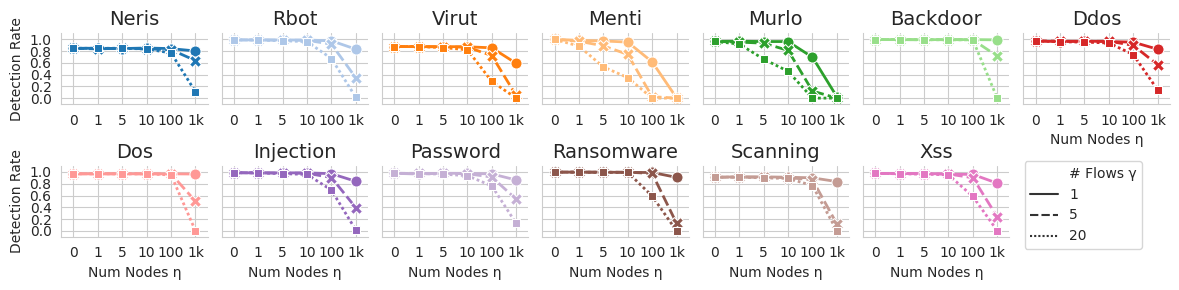

In [13]:
model = 'egraphsage' # change with linegraphsage
sns.set_style('whitegrid')
atk_type = 'add_node'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}.csv", index_col=0)
        
e_graphsage_data = produce_add_node_data(baseline_dict, atk_dict)
fig = produce_plot_all_addnode(e_graphsage_data)
fig.savefig(f"figures/total/{model}_{atk_type}_big.pdf")